# The DataStats Hypotest Module
The datastats.hypotest module contains classes for conducting various types of hypothesis tests 
using non-parametric computational methods, inspired by the methods used in Allen Downey's book Think Stats.  

These classes all have the following attributes and methods.

#### Attributes
data:  
The original data

test_stat:  
The test statistic used in the hypothesis test

rv:   
A scipy.stats discrete_rv object (random variable) 
that represents the sampling distribution.  
This object provides numerous useful attributes and methods
See the discrete_rv documentation for details

#### Methods
PValue():  
Computes the p-value for the hypothesis test

PlotCdf():
Draws a Cdf of the distribution with a vertical line at the test statcan produce p-values

Power(alpha=0.05, num_runs=1000):  
Computes the power of the hypothesis test at a given significance level (alpha)
This method simulates resampling from the population and then runs the same hypothesis test used to compute the p-value a number of times equal to num_runs. The returned result is the proportion of times that the test returned a statistically significant result at the given alpha.  
Be advised that this method does a lot of computations so it does take some time to run at higher numbers of iterations (num_runs).

MinMaxTestStat():  
Returns the smallest and largest test statistics in the sampling distribution

There are also some additional functions included in this module for chi square and ANOVA post-hoc analysis.

It's also possible to use the base HypothesisTest class as a parent class to build further hypothesis test classes in a similar manner to those included in this module.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats

from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datastats.hypotest as dsht
from datastats.singlevar import ListsToDataFrame

For the first few examples I will use the seaborn 'penguins' dataset, and reduce to just a subset of this data: the "Adelie" species of penguin.

In [2]:
penguins_df=sns.load_dataset("penguins")
penguins_df.dropna(inplace=True)
adelie_df = penguins_df[penguins_df.species == 'Adelie']
adelie_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


## HTMean

This class is used to run a hypothesis test using a known average mean.

For this demonstration, let's assume that we have a known average body mass for Adelie penguins of 3700 grams. Then we measured the body mass of a group of Adelie penguins from one island and we want to check if the body mass of these penguins is larger than the known average. In this kind of situation, when we only have an already known test statistic to compare with our data, we can use HTMean to run our hypothesis test.

HTMean is only capable of running one-sided hypothesis tests.

In [3]:
# For this demonstration we will use the body masses of Adelie penguins from just Torgersen island.
adelie_mass_HTMean = dsht.HTMean(data=adelie_df[adelie_df.island == 'Torgersen'].body_mass_g, 
                                 test_stat=3650, 
                                 tail='left', 
                                 iters=1000)
adelie_mass_HTMean.PValue()

0.18500000000000014

This p-value tells us that the difference between the previously known average Adelie penguin body mass and the body masses of the Adelie penguins on this island is not statistically significant at any normally acceptable significance level.

## HTDiffMeansH0

This class is used to run a difference of means hypothesis test. The 'H0' in this class name means that the function uses random resampling of pooled data to build a sampling distribution of the null hypothesis, and the test statistic from the original data is tested against that.

HTDiffMeansH0 can run both one-sided and two-sided hypothesis tests.

For this demonstration we will check to see if there is a statistically significant difference in flipper length between male and female Adelie penguins in this dataset. 

From a plot of the data, it looks like there is a potentially significant difference between the flipper lengths of the male and female penguins.

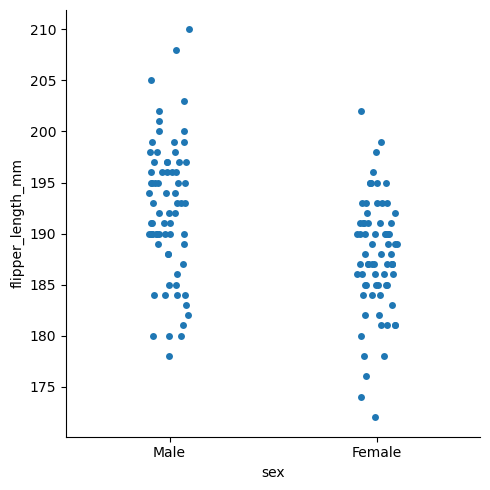

In [4]:
sns.catplot(x='sex', y='flipper_length_mm', data=adelie_df)

Let's compute the difference in mean flipper length of male and female Adelie penguins in the dataset. This will be the test statistic in our hypothesis test.

In [5]:
abs(adelie_df[adelie_df.sex == 'Male'].flipper_length_mm.mean() - 
    adelie_df[adelie_df.sex == 'Female'].flipper_length_mm.mean())

4.616438356164366

Let's now run a hypothesis test using to HTDiffMeansH0 to check whether this difference is statistically significant.

In [6]:
male_flipper_length = adelie_df[adelie_df.sex == 'Male'].flipper_length_mm
female_flipper_length = adelie_df[adelie_df.sex == 'Female'].flipper_length_mm

flipper_length_HTDiffMean_H0 = dsht.HTDiffMeansH0(data=(male_flipper_length, female_flipper_length), 
                                                  onesided=False, 
                                                  tail='right', 
                                                  iters=1000)
flipper_length_HTDiffMean_H0.PValue()

0.0

We obtained a result of 0 for the p-value, which means that a value as high as our test statistic was never reached in any of the 1000 iterations run to build the sampling distribution. This can visualized using the PlotCdf method of HTDiffMeansH0.

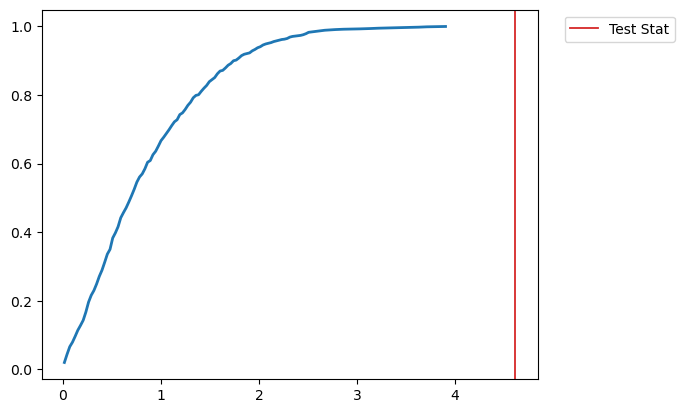

In [7]:
flipper_length_HTDiffMean_H0.PlotCdf()

If we want to see how close the test stats produced in our iterations came to reaching the actual test stat, we can use the MinMaxTestStat method.

In [8]:
flipper_length_HTDiffMean_H0.MinMaxTestStat()

(0.013698630136985912, 3.9041095890410986)

We can also now run the Power method of HTDiffMeansH0 to check this test's ability to correctly reject the null hypothesis. We will reduce the number of runs from the default of 1000 to 100 in order to decrease the computation time.

In [9]:
flipper_length_HTDiffMean_H0.Power(alpha=0.05, num_runs=100)

1.0

The power of this test is nearly 1.0, meaning that it correctly rejects the null nearly 100% of the time, which is far above the generally accepted 0.8 threshold.

## HTDiffMeansHa

Like HTDiffMeansH0, this class is also used to run difference of means hypothesis tests, except it uses random resampling of the separated groups (no pooling) to build a sampling distribution of the alternative hypothesis. For this class, a test statistic for the null hypothesis must be provided by the user. For example, if our null hypothesis is no difference between the groups, then a test stat of 0 can be provided.

HTDiffMeansHa is only capable of running one-sided hypothesis tests.

In [10]:
flipper_length_HTDiffMean_Ha = dsht.HTDiffMeansHa(data=(male_flipper_length, female_flipper_length), 
                                                  test_stat=0, 
                                                  tail='left', 
                                                  iters=1000)
flipper_length_HTDiffMean_Ha.PValue()

0.0

This test also gives us a p-value of 0, as we would expect.

The cdf plot is a different shape compared to that shown above in the HTDiffMeansH0 example because this is a one-sided test, and we can see that our test stat is at 0, representing the null hypothesis of no difference.

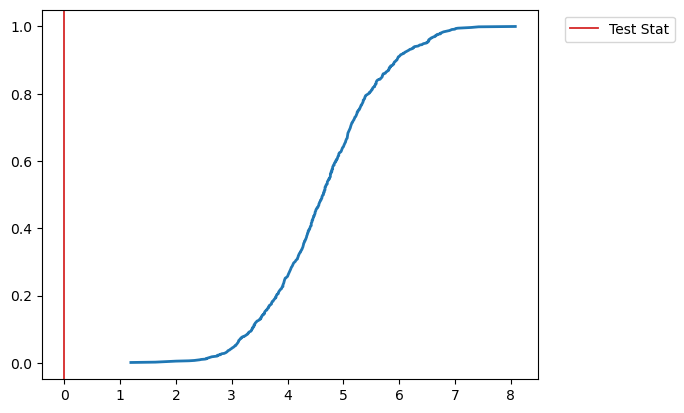

In [11]:
flipper_length_HTDiffMean_Ha.PlotCdf()

## HTCorrelationH0

The HTCorrelationH0 class is used to conduct correlation hypothesis tests. The 'H0' in this class name means that the function uses random permutation to simulate no correlation and build a sampling distribution of the null hypothesis. The test statistic from the original data is then tested against that.

Note that there is also an HTCorrelationHa class in the hypotest module, but this will not be demonstrated here.

For this demostration we will look at whether or not there is a statistically significant correlation between bill length and flipper length in the Adelie penguins in our dataset.

First we can check out what the data looks like in a scatterplot.

<AxesSubplot: xlabel='bill_length_mm', ylabel='flipper_length_mm'>

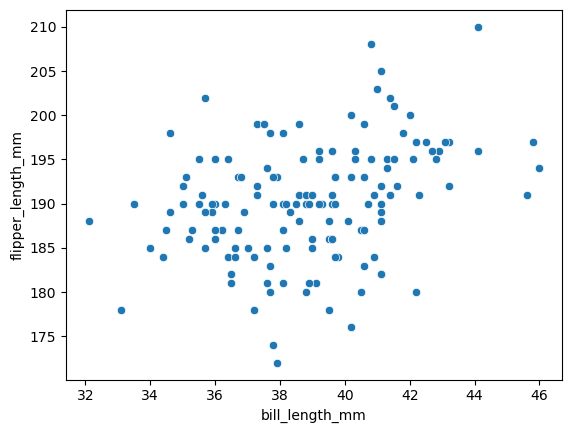

In [12]:
sns.scatterplot(x=adelie_df.bill_length_mm, y=adelie_df.flipper_length_mm, data=adelie_df)

For comparison with a parametric calculation of the pvalue, let's first run pearsonr from scipy stats.

In [13]:
pearsonr_results = stats.pearsonr(adelie_df.bill_length_mm, adelie_df.flipper_length_mm)
print ('r =', pearsonr_results[0], 'pvalue =', pearsonr_results[1])

r = 0.3322739620956147 pvalue = 4.1780282593645075e-05


Let's now run HTCorrelationH0, using the pearson method for computing the correlation. We can change the method to spearman also if we want to.

In [14]:
length_depth_corr_H0 = dsht.HTCorrelationH0(data=(adelie_df.bill_length_mm, adelie_df.flipper_length_mm),
                                            onesided=False,
                                            tail='right',
                                            iters=1000,
                                            method='pearson')
print('r =', length_depth_corr_H0.test_stat, 'pvalue =',length_depth_corr_H0.PValue())

r = 0.3322739620956147 pvalue = 0.0


We get a pvalue of 0 here which agrees with the very low pvalue returned from scipy stats pearsonr.

The r value tells us that the correlation is not very strong, which can be seen in the scatterplot as well. However our low pvalue tells us that, although the correlation is not strong, it is statistically significant.

We can also run MinMaxTestStat and plot our sampling distribution, as we did in previous examples.

In [15]:
length_depth_corr_H0.MinMaxTestStat()

(1.604931969718948e-05, 0.24018187758309364)

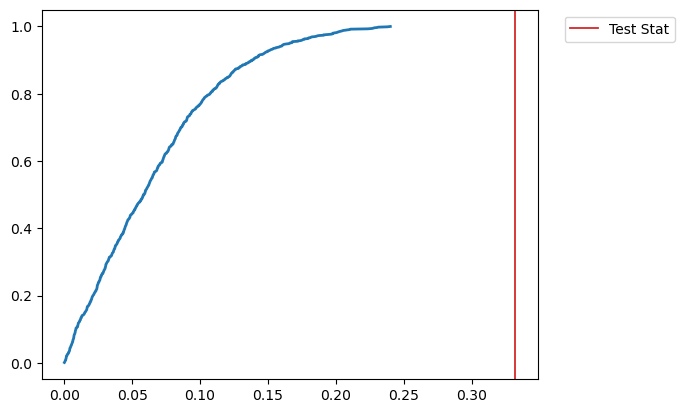

In [16]:
length_depth_corr_H0.PlotCdf()

In [17]:
length_depth_corr_H0.Power(alpha=0.05, num_runs=100)

0.96

For this test as well, the power is close to 1.0 so it's able to correctly reject the null hypothesis nearly 100% of the time. 

## HTChiSquare

The HTChiSquare class is used to conduct chi square hypothesis tests in which a sequence of observed values is compared against a sequence of expected values. The length of the sequences must be the same and the sum of the values in the sequences must be equal.

Note that if the sum of the sequence values is different, you can still use this class by first normalizing the expected values and then creating a new expected values sequence by multiplying by the total number of observed values: 
adjust_expected = expected/sum(expected)*sum(observed)

For this example I'll use some made up data to test the fairness of a die over 60 rolls.

In [18]:
rolls_expected = [10,10,10,10,10,10]
rolls_observed = [4,8,18,8,12,10]

In [19]:
dice_chi = dsht.HTChiSquare(data=(rolls_expected, rolls_observed),
                            tail='right',
                            iters=1000)
dice_chi.PValue()

0.01799999999999924

We got a pvalue that is around the level which is generally accepted as statistically significant. 

As in other examples we can plot the sampling distribution to see what it looks like.

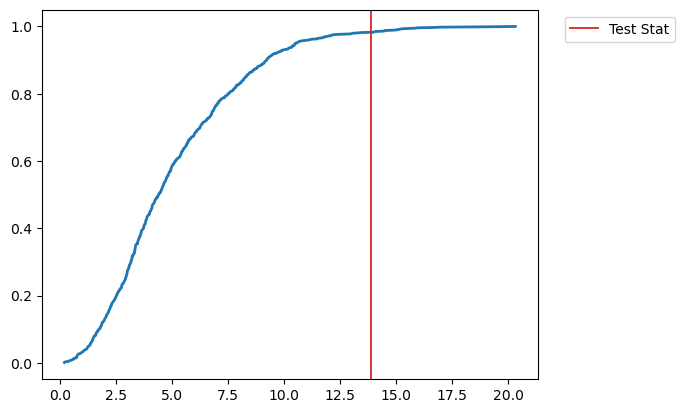

In [20]:
dice_chi.PlotCdf()

We can also compute the power of this test.

In [21]:
dice_chi.Power(alpha=0.05, num_runs=100)

0.81

In this example the power of the test is right around the normally accepted threshold of 0.8.

## HTChiSquareContingency

The HTChiSquareContingency class is used to conduct chi square hypothesis tests from a contingency table. This kind of test is used to determine whether two categorical variables are independent or not. A low pvalue indicates that the variables are related and that we should reject the null hypothesis of independence.

For this demonstration, we will use the titanic dataset and look at whether passenger class and survival are independent or not.

In [22]:
# Use titanic dataset for chi-squared contingency
titanic_df = sns.load_dataset('titanic')
titanic_df.dropna()
titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [23]:
titanic_crosstab = pd.crosstab(index=titanic_df.survived, columns=titanic_df.pclass)
titanic_crosstab

pclass,1,2,3
survived,,,
0,80,97,372
1,136,87,119


First let's run scipy stats chi2_contingency test to get a pvalue for comparison.

In [24]:
results = stats.chi2_contingency(titanic_crosstab)
print('pvalue:', results[1])

pvalue: 4.549251711298793e-23


Now let's run HTChiSquareContingency to see the pvalue we get.

In [25]:
titanic_chi_contingent = dsht.HTChiSquareContingency(data=titanic_crosstab,
                                                     tail='right',
                                                     iters=1000)
titanic_chi_contingent.PValue()

0.0

We got a pvalue of 0 which agrees with the very low pvalue from scipy stats.chi2_contingency. 

The plot shows us just how far the test stat from our data is from the null hypothesis sampling distribution, which again reflects the very low pvalue and strong relationship between the two variables.

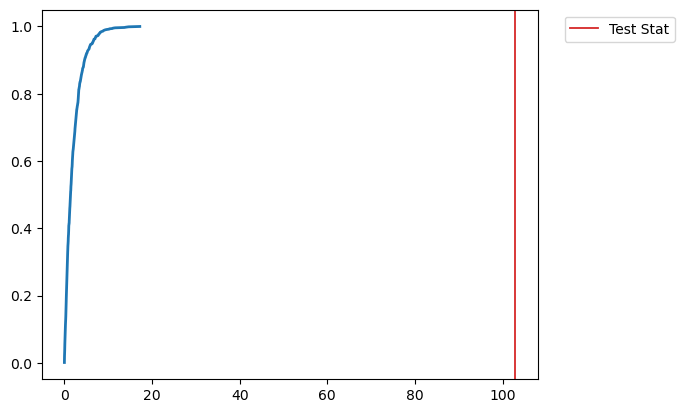

In [26]:
titanic_chi_contingent.PlotCdf()

Since the two variables are clearly related, we can use the use the ChiSquareContribution function for post-hoc analysis to see what categories within the variables contributed the most to the result.

First we will use the ExpectedFromObserved function to get the expected frequency array to use in this post-hoc analysis.

In [27]:
titanic_expected_array = dsht.ExpectedFromObserved(titanic_crosstab)
titanic_expected_array

array([[133.09090909, 113.37373737, 302.53535354],
       [ 82.90909091,  70.62626263, 188.46464646]])

In [28]:
dsht.ChiSquareContribution(titanic_crosstab, titanic_expected_array)

pclass,1,2,3
survived,,,
0,21.178341,2.364739,15.949664
1,33.996810,3.796028,25.603407


Looking at this result, we can see that the biggest contributions came from the passenger class 1 and passenger class 3 categories.

## HTOnewayAnova

The HTOnewayAnova class is used to conduct ANOVA hypothesis tests. This kind of test is used to determine if there is a statistically significant difference in means between more than two groups.

For this demonstration, we will use some data that comes from an example used in the f_oneway function in scipy stats:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

This data consists of shell measurements in the mussel Mytilus trossulus from five locations:
Tillamook, Oregon; Newport, Oregon; Petersburg, Alaska; Magadan, Russia; and Tvarminne, Finland.

In [29]:
tillamook = [0.0571, 0.0813, 0.0831, 0.0976, 0.0817, 0.0859, 0.0735,
             0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835,
           0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764,
           0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]

mussel_type_names = ['tillamook', 'newport', 'petersburg', 'magadan', 'tvarminne']
mussels_data_list = [tillamook, newport, petersburg, magadan, tvarminne]

First we will use the ListsToDataFrame function from the single var module to put the data into a DataFrame format.

In [30]:
mussels_df = ListsToDataFrame(data=mussels_data_list,
                              group_labels=mussel_type_names,
                              group_col_name='mussel_type',
                              values_col_name='value')
mussels_df.head()

,mussel_type,value
0,tillamook,0.0571
1,tillamook,0.0813
2,tillamook,0.0831
3,tillamook,0.0976
4,tillamook,0.0817


Let's use the scipy stats f_oneway function to get a pvalue for comparison.

In [31]:
stats.f_oneway(*mussels_data_list)

F_onewayResult(statistic=7.121019471642447, pvalue=0.0002812242314534544)

Since we obtained a statistically significant results, let's also use the statsmodels pairwise_tukeyhsd function to run post-hoc analysis to see which pairs of groups have statistically significant differences.

In [32]:
mussels_results = pairwise_tukeyhsd(endog=mussels_df.value, groups=mussels_df.mussel_type, alpha=0.05)
mussels_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
magadan,newport,-0.0032,0.9858,-0.0213,0.0149,False
magadan,petersburg,0.0254,0.0037,0.0067,0.0442,True
magadan,tillamook,0.0022,0.996,-0.015,0.0194,False
magadan,tvarminne,0.0177,0.0929,-0.0019,0.0373,False
newport,petersburg,0.0286,0.0009,0.0099,0.0474,True
newport,tillamook,0.0054,0.8935,-0.0118,0.0226,False
newport,tvarminne,0.0209,0.0317,0.0013,0.0405,True
petersburg,tillamook,-0.0232,0.0057,-0.0411,-0.0054,True
petersburg,tvarminne,-0.0077,0.8028,-0.0279,0.0124,False
tillamook,tvarminne,0.0155,0.1447,-0.0032,0.0342,False


Now let's use our HTOnewayAnova class to see what pvalue we get.

In [33]:
mussels_ANOVA = dsht.HTOnewayAnova(data=mussels_data_list,
                                   tail='right',
                                   iters=1000)
mussels_ANOVA.PValue()

0.0009999999999992237

We get a pvalue of 0, which agrees with the low pvalue from stats.f_oneway.

And when we plot it we can see that the test stat is relatively close to the null hypothesis sampling distribution but that none of the sampling distribution values are as high as our test stat.

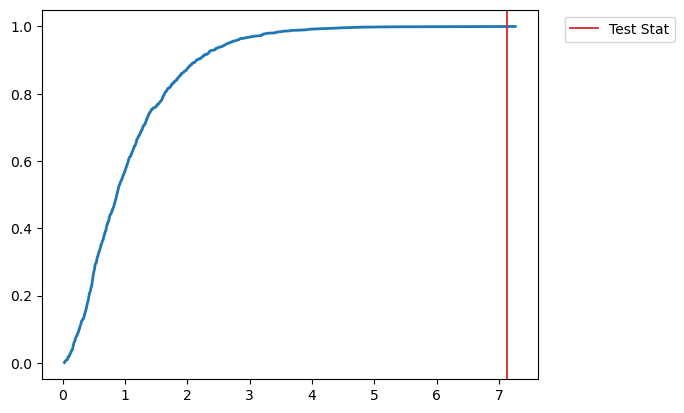

In [34]:
mussels_ANOVA.PlotCdf()

Next let's use AnovaPostHoc to run our post-hoc analysis.

In [35]:
results, adj_alpha = dsht.AnovaPostHoc(data=mussels_data_list, labels= mussel_type_names)
print('Adjusted alpha:', adj_alpha)
results

Adjusted alpha: 0.005


[(('tillamook', 'newport'), '0.311', 'N'),
 (('tillamook', 'petersburg'), '0.001', 'Y'),
 (('tillamook', 'magadan'), '0.729', 'N'),
 (('tillamook', 'tvarminne'), '0.026', 'N'),
 (('newport', 'petersburg'), '0', 'Y'),
 (('newport', 'magadan'), '0.599', 'N'),
 (('newport', 'tvarminne'), '0.007', 'N'),
 (('petersburg', 'magadan'), '0.001', 'Y'),
 (('petersburg', 'tvarminne'), '0.365', 'N'),
 (('magadan', 'tvarminne'), '0.04', 'N')]

The adjusted alpha is the significance level applied to each pair in the results. The results show the pvalue and whether or not the pvalue is significant (Y or N) for each pairing. If the pvalue is less than this adjusted alpha then we can say that the difference in means for the pair is statistically significant.

In our results we get pvalues that are statistically significant, or very close to the adjusted alpha threshold, for the following pairs:  
'newport', 'petersburg'  
'petersburg', 'magadan'  
'tillamook', 'petersburg'  
'newport', 'tvarminne'

And this corresponds to the results from statsmodels pairwise_tukeyhsd.

Note that the significance Y/N results we get from our method vary each time it's run. The four pairs listed above sometimes come out as significant and sometimes not. This is because random sampling is used instead of parametrics methods. This reality should serve as a reminder that a pvalue which barely meet a threshold for significance is not really different from ones that barely don't.